# Homework 1 - Train and Evaluate a Classifier on your Own Images
In this assignment, you will train and evaluate your own image classifier.

Completing this homework will give you practice

- Working with image datasets
- Training image classifiers
- Evaluating image classifiers
- Explaining your decisions and their possible consequences.<br>

[Link to HW Assignment](https://cs.calvin.edu/courses/cs/375/24sp/units/02supervised/homework/)

# Setup

In [151]:
!pip list | egrep 'keras|tensorflow$'

keras                                    2.15.0
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.4.6


In [152]:
import os
# Results are better with the TensorFlow backend; this is probably a bug in Keras 3 but I haven't tracked it down.
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

Keras version: 2.15.0, backend: tensorflow
GPUs: 0


# Configure our Experiment

In [153]:
class config:
    seed = 155
    learning_rate = 1e-3
    epochs = 4
    batch_size = 10
    image_size = (256, 256)
    model_preset = "efficientnetv2_b0_imagenet"
    use_zero_init = True

In [154]:
# Reproducibility
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
#
# Set a seed so that the results are the same every time this is run.
keras.utils.set_random_seed(config.seed)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

# Load our Data

In [155]:
# Load data
path_to_download_file = keras.utils.get_file(
    origin="https://students.cs.calvin.edu/~tja9/images.zip",
    extract=True,
)

In [156]:
data_path = Path(path_to_download_file).parent / 'images'
!ls {data_path}

README.txt  a  b  c


In [157]:
#Define which classes we want to use, in what order.
class_names = ['a', 'b', 'c']

#Create training and validation datasets
#0.7 validation split has good readings
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=128,
    subset='both',
    crop_to_aspect_ratio=True   
)

Found 60 files belonging to 3 classes.
Using 48 files for training.
Using 12 files for validation.


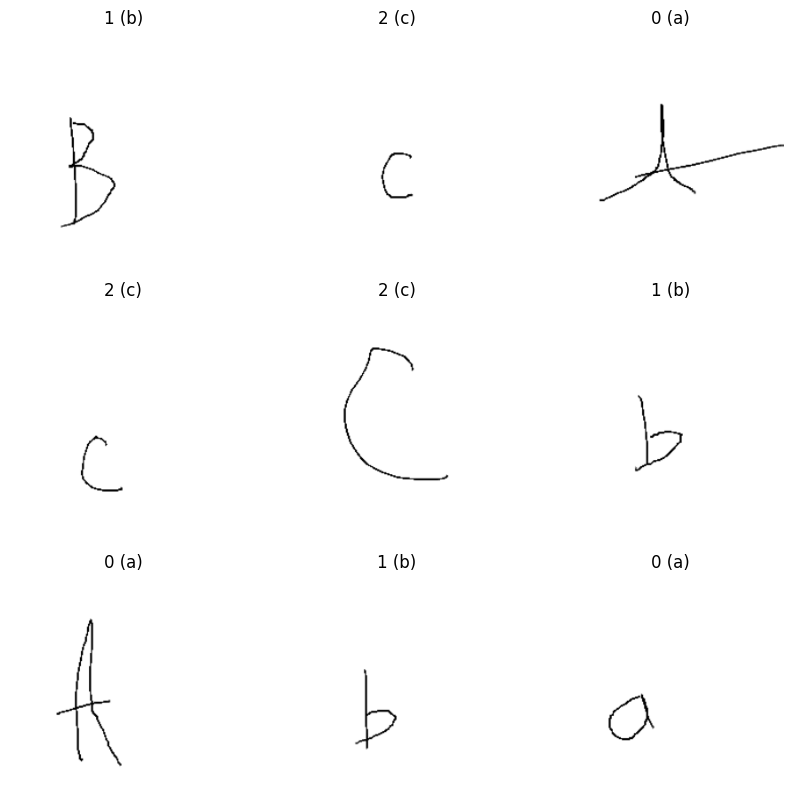

In [158]:
[[example_images, example_labels]] = train_dataset.take(1)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.array(example_images[i]).astype('uint8'))
    label = example_labels[i]
    ax.set(title=f"{label} ({class_names[label]})")
    ax.axis('off')
# Alternative approach (doesn't show labels)
# keras_cv.visualization.plot_image_gallery(example_images, value_range=(0, 255))

# Train our Model

In [159]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Zero the output-layer weights (they were randomly initialized, which adds noise to gradients when fine-tuning)
# I was reminded of this by https://twitter.com/wightmanr/status/1742570388016758822
if config.use_zero_init:
    output_layer = model.layers[-1]
    output_layer.set_weights([w * 0 for w in output_layer.weights])

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

# Train the model. (Note: this may show some warnings, and it may stop without showing
# progress for up to a minute while it translates the model to run on the GPU.)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs
)

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "image_classifier_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_5 (InputLayer)        [(None, None, None, 3)]   0         Y          
                                                                            
 efficient_net_v2b0_backbon  (None, None, None, 1280   5919312   Y          
 e (EfficientNetV2Backbone)  )                                              
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1280)              0         Y          
 ling2D)                                                                    
                                                                            
 predictions (Dense)         (None, 3)                 3843      Y          
                                                                            
Total params: 5923155 (22.60 MB)
Trainable param

- Training Set Accuracy: 95.83%
- Validation Set Accuracy: 100%
- Training Loss: 23.5%
- Validation Loss: 19.51%

# Visualize Things:
**- What does your data look like?**

In [160]:
example_images.shape

TensorShape([10, 256, 256, 3])

**- What do the predictions of your classifier look like?**

I am now going to feed the example dataset that you had in the [HW01 directions]("https://students.cs.calvin.edu/~ka37/example_letter_images.zip") to see what the predictions of my classifier looks like

# Letter A

In [181]:
from ipywidgets import widgets
uploader1 = widgets.FileUpload()
uploader1

FileUpload(value={}, description='Upload')

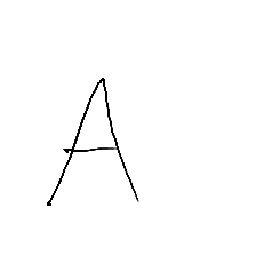

In [182]:
if len(uploader1.data) > 0:
    image_file1 = io.BytesIO(uploader1.data[0])
    image1 = keras.utils.load_img(image_file1, target_size=(256, 256), keep_aspect_ratio=True)
    display(image1)

In [183]:
probabilities1 = model.predict(np.array(image1)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities1}).sort_values('prob', ascending=False)

1/1 [==============================] - 0s 94ms/step


,class,prob
0,a,0.972446
2,c,0.017724
1,b,0.009829


# Letter B

In [213]:
from ipywidgets import widgets
uploader2 = widgets.FileUpload()
uploader2

FileUpload(value={}, description='Upload')

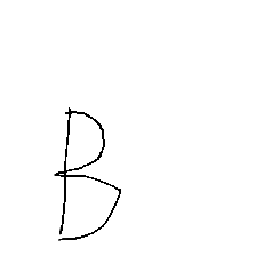

In [214]:
if len(uploader2.data) > 0:
    image_file2 = io.BytesIO(uploader2.data[0])
    image2 = keras.utils.load_img(image_file2, target_size=(256, 256), keep_aspect_ratio=True)
    display(image2)

In [215]:
probabilities2 = model.predict(np.array(image2)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities2}).sort_values('prob', ascending=False)

1/1 [==============================] - 0s 80ms/step


,class,prob
1,b,0.939355
2,c,0.044782
0,a,0.015863


# Letter C

In [167]:
from ipywidgets import widgets
uploader3 = widgets.FileUpload()
uploader3

FileUpload(value={}, description='Upload')

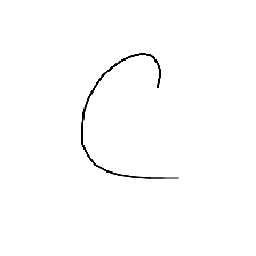

In [185]:
if len(uploader3.data) > 0:
    image_file3 = io.BytesIO(uploader3.data[0])
    image3 = keras.utils.load_img(image_file3, target_size=(256, 256), keep_aspect_ratio=True)
    display(image3)

In [186]:
probabilities3 = model.predict(np.array(image3)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities3}).sort_values('prob', ascending=False)

1/1 [==============================] - 0s 96ms/step


,class,prob
2,c,0.993133
1,b,0.005181
0,a,0.001687


# What does the confusion matrix look like?

In [170]:
from sklearn.metrics import ConfusionMatrixDisplay

In [171]:
val_predicted_probs = model.predict(val_dataset)

2/2 [==============================] - 2s 78ms/step


In [172]:
val_predicted_probs.shape

(12, 3)

In [173]:
val_predictions = np.argmax(val_predicted_probs, axis=1)
val_labels = [int(label) for img, label in val_dataset.unbatch()]

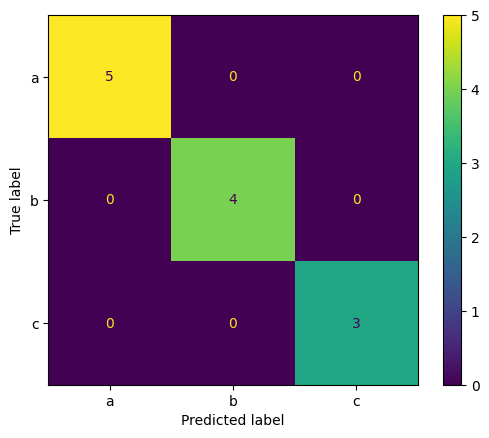

In [174]:
ConfusionMatrixDisplay.from_predictions(val_labels, val_predictions, display_labels=class_names)

# Analysis
- **Description of data set:**
 - How many images did you have of each class
   - I had 20 images in each class. There were 10 uppercase and 10 lowercase of each letter
 - How did you collect the images(e.g, whether you used a mouse/finger/pen or took pictures of paper/whiteboard/chalkboard/documents you found in the Meeter Center/...)
   - I collected the images by using a mouse and writing the letters onto the webapp that you created
- **How many images do you have in your classifier's training and validation sets?**
 - I have 48 images in my training dataset and 12 in my validation set
- **Evaluations of the model on your validation set**
 - How accurate is the classifier overall?
   - With the training and validation sets that I provided my model with, here are it's calculations:
     - Training Set Accuracy: 95.83%
     - Validation Set Accuracy: 100%
     - Training Loss: 23.5%
     - Validation Loss: 19.51%
 - Which letter is your model most successful at classifying? Give an example of a correctly classified image(show specific image file and its classification).
   - The model was most successful at identifying the letter "C". Above, in the "Vizualize Things" section of this notebook, I tried out predict different letter, not in my dataset, I utilized the dataset that you provided in the Homework 01 instructions. In addtion, the letter "C" was the only letter that consistently had an accuracy above 99%

In [175]:
from ipywidgets import widgets
uploader4 = widgets.FileUpload()
uploader4

FileUpload(value={}, description='Upload')

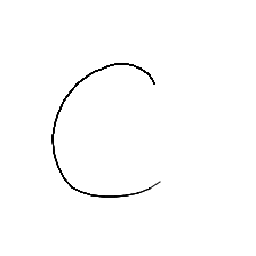

In [187]:
if len(uploader4.data) > 0:
    image_file4 = io.BytesIO(uploader4.data[0])
    image4 = keras.utils.load_img(image_file4, target_size=(256, 256), keep_aspect_ratio=True)
    display(image4)

In [188]:
probabilities4 = model.predict(np.array(image4)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities4}).sort_values('prob', ascending=False)

1/1 [==============================] - 0s 74ms/step


,class,prob
2,c,0.993751
1,b,0.004287
0,a,0.001962


 - What mistakes does it make most frequently? Give an example of a mistake(show a specific image file and its classification).
   - The mistake that my model makes most frequently is mix us the letter "B". I believe it is because of the quality of the way the "B" is written in my dataset compared to the way the "B" is written in the provided dataset. So, it will sometime mix that letter up with a "C". 

In [192]:
from ipywidgets import widgets
uploader5 = widgets.FileUpload()
uploader5

FileUpload(value={}, description='Upload')

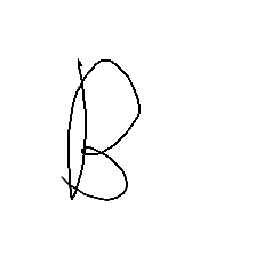

In [193]:
if len(uploader5.data) > 0:
    image_file5 = io.BytesIO(uploader5.data[0])
    image5 = keras.utils.load_img(image_file5, target_size=(256, 256), keep_aspect_ratio=True)
    display(image5)

In [194]:
probabilities5 = model.predict(np.array(image5)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities5}).sort_values('prob', ascending=False)

1/1 [==============================] - 0s 78ms/step


,class,prob
1,b,0.512220
2,c,0.449124
0,a,0.038657


 - **For the previous 3 questions, any ideas about why?**
   - For the first question, I think that the model was for the most part successful because we letters were pretty similar, but I also gave a variety of them as well in the way they were written.
   - For the second question,I think the model was most accurate at predicting the letter "C" because when I was looking at my dataset of C and the dataset provided in the instructions, they were fairly similar, and not much were differnt in the shape of them, which could lead to the better accuracy scores.
   - For the third question, I think that because the "B"'s in my dataset were quite different than the B's in the datset provided in the instructions, the model had a difficult time differentiating them. There are curves within the "B", so that might have it think it's "C" as well.
 - **Generalization: Suppose someone else gave you one of their images. How likely do you think your classifier would be to get it right, and why? report your answer in terms of a percentage, either overall or broken down by which letter.**
   - That is what I tried to display in my notebook, I utilized a different dataset(the one listed in the instructions), and I believe that the scores were pretty accurate execept for some like in the example above for the letter "B". I think if I were to increase the dataset and training it more on a larger variety of hand writtings, it would increase the score for a someone elses's hand writting.
- **What choices did you have to make in the process of collecting data, processing it, and analyzing the results?**
  - In the process of collecting the data, I had to make the choices of how many images should be in each class/folder, how many uppercase and lowercase letters there should be, and the way the letters should be written.
  - In the process of processing the data, I had to make the choice of what parameters do I need to make adjustments to in order to improve the accuracy scores of my model.
  - In the process of analyzing the results, I had to sometimes figure out my model wasn't working as intended and then I had to make the choice of how I need to change my model in order to have it work the way I wanted it to.
- **What are one or two choices that you could have made differently?**
  - I think one change that I would have made differently is have more examples/data within my dataset, both testing and validation sets. I think if the model had more example, it could learn better. In addition, I would improve the quality of some of the letter. Some letters, for example B, were hard to draw using a mouse. So, next time I would try to maybe write out the letters and take an image of them to get a better depiction of the letter.
- **What do you expect would be different if you made that different choice?**
  - If I were to those different choices, I think the accuracy of the model would increase and also the prediction of the letters would become better. The model would be a better sense of the patterns in each letter, which would result in better accuracy scores.